# Setup and Preparations for Predictions

In [40]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# set random seed for all algos
rseed = 42

# suppress future warnings for xgboost in this notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# plotting style for plots later on
plt.style.use("seaborn")

In [41]:
def plot_hist(df, feature, title):
    
    feature_mean = round(df[f"{feature}"].mean()).astype("int64")

    plt.figure(figsize=(15,5))

    ax = sns.distplot(df[f"{feature}"], bins = 20, kde=False)

    plt.ticklabel_format(style='plain', axis='x')
    ax.tick_params(labelsize=14)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    plt.axvline(feature_mean, color='b', linestyle='dashed', linewidth=2, ymax=0.95, label="Mean")

    ax.set_ylabel("count", fontsize = 16)
    ax.set_xlabel(f"{feature}", fontsize = 16)
    ax.set_title(f"{title}",fontsize = 20)
    
    ### text box, for fast visualisation of key values
    
    # defining key values for texr box
    min_value = round(df[f"{feature}"].min()).astype("int64")
    max_value = round(df[f"{feature}"].max()).astype("int64")
    mean_value = round(df[f"{feature}"].mean()).astype("int64")
    
    # put key values in joined text-string
    textstr = '\n'.join((
        f"min value = {min_value:0,}",
        f"max value = {max_value:0,}",
        f"mean value = {mean_value:0,}"))
    
    # define box style
    props = dict(boxstyle='round', facecolor='blue', alpha=0.2)

    # place text box on the right with x and y coordinates
    ax.text(0.75, 0.6, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='center', bbox=props)

    
    if feature == "market_value_€":
        
        import matplotlib.ticker as plticker
        
        plt.xticks(rotation='vertical')

        #set tick every 10 Mio €
        tick_spacing = 10000000
        loc = plticker.MultipleLocator(tick_spacing)
        ax.xaxis.set_major_locator(loc)
        
        plt.legend(prop={'size': 15})
        plt.show();
    
    else:
        plt.legend(prop={'size': 15})
        plt.show();

##### Prepare datasets for prediction

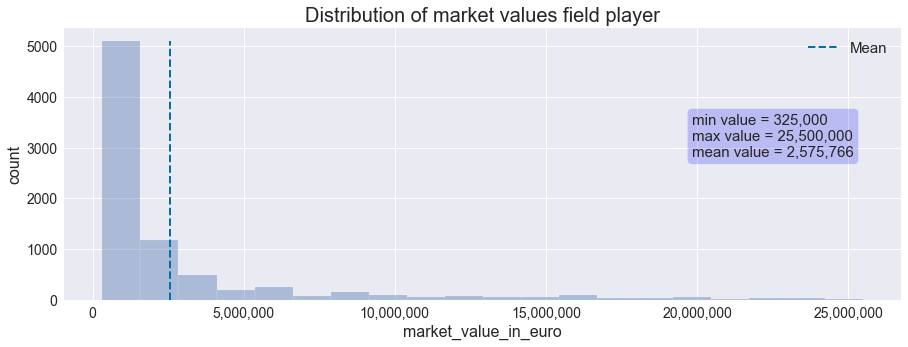

None


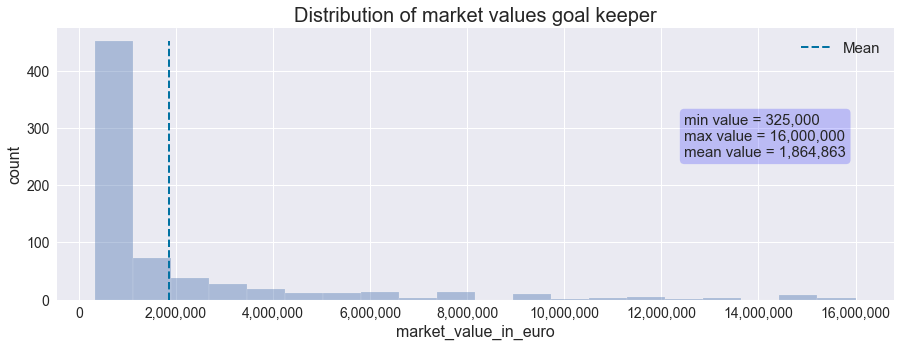

None


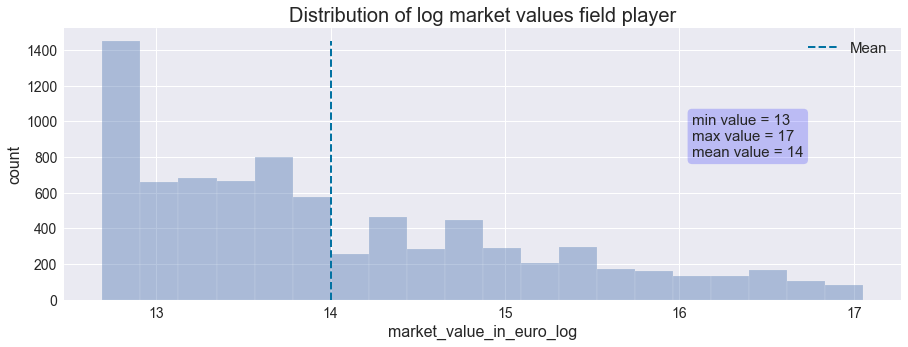

None


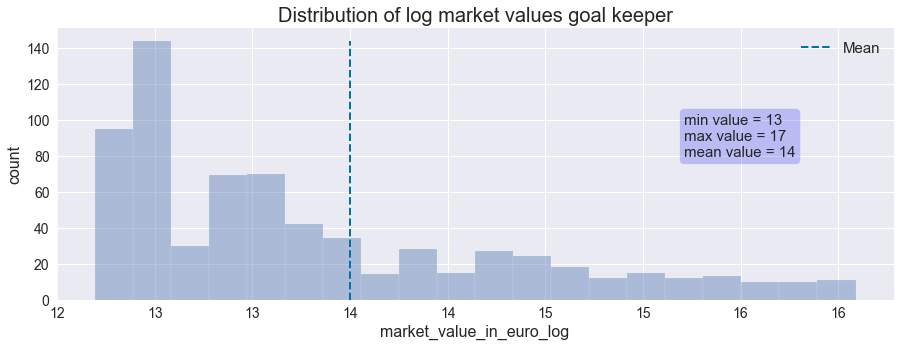

None


In [42]:
df_fp = pd.read_csv("data/fp_data_final.csv", index_col=0)
df_gk = pd.read_csv("data/gk_data_final.csv", index_col=0)
pd.set_option('display.max_columns', None)

##########################EXPERIMENTAL
df_fp = df_fp[df_fp.market_value_in_euro > 300000]
df_gk = df_gk[df_gk.market_value_in_euro > 300000]
##########################EXPERIMENTAL
# drop irrelevant rows

df_fp = df_fp.drop(["player_name","long_name","year_of_birth","height_cm","weight_kg","nationality","club"],axis=1)
df_gk = df_gk.drop(["player_name","long_name","year_of_birth","height_cm","weight_kg","nationality","club"],axis=1)

# transform target variable
print(plot_hist(df_fp,"market_value_in_euro","Distribution of market values field player"))
print(plot_hist(df_gk,"market_value_in_euro","Distribution of market values goal keeper"))

df_fp["market_value_in_euro_log"] = np.log(df_fp["market_value_in_euro"])
df_gk["market_value_in_euro_log"] = np.log(df_gk["market_value_in_euro"])

df_fp = df_fp.drop(["market_value_in_euro"], axis = 1)
df_gk = df_gk.drop(["market_value_in_euro"], axis = 1)

print(plot_hist(df_fp,"market_value_in_euro_log","Distribution of log market values field player"))
print(plot_hist(df_gk,"market_value_in_euro_log","Distribution of log market values goal keeper"))

In [43]:
##### put final test set aside

# fieldplayers
train_set_fp = df_fp.sample(frac=0.80, random_state=rseed)
final_test_set_fp = df_fp.drop(train_set_fp.index)

# goal keepers
train_set_gk = df_gk.sample(frac=0.80, random_state=rseed)
final_test_set_gk = df_gk.drop(train_set_gk.index)

print("Fieldplayers: ")
print(train_set_fp.shape)
print(final_test_set_fp.shape)
print("-----------------------")
print("Goalkeepers: ")
print(train_set_gk.shape)
print(final_test_set_gk.shape)

Fieldplayers: 
(6426, 54)
(1606, 54)
-----------------------
Goalkeepers: 
(554, 37)
(139, 37)


## Feature Selection

##### Check for correlations before processing with heatmap

In [44]:
def plot_heatmap (data):
    
    corrmat = data.corr()
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(16, 10))
        ax.xaxis.tick_top() 
        cmap = sns.color_palette("RdBu_r", 10)
        matrix = np.tril(corrmat)
        
    if len(data.columns) < 15:
    
        sns.set(context="paper", font="monospace", font_scale=2)

        with sns.axes_style("white"):
            heatmap = sns.heatmap(corrmat[(corrmat >= 0.8) | (corrmat <= -0.4)], 
                                  cmap=cmap, vmin=-1, vmax=1, center= 0, square=True, annot=True, 
                                  annot_kws={"size": 12}, fmt='.2g', mask=matrix, linewidths=1, rasterized=True);
    
    elif len(data.columns) <= 30:
        
        sns.set(context="paper", font="monospace", font_scale=1.5)
        
        with sns.axes_style("white"):
            heatmap = sns.heatmap(corrmat[(corrmat >= 0.8) | (corrmat <= -0.4)], 
                                  cmap=cmap, vmin=-1, vmax=1, center= 0, square=True, annot=True, 
                                  annot_kws={"size": 10}, fmt='.1g', mask=matrix, linewidths=1, rasterized=True);
    
    else:
        
        sns.set(context="paper", font="monospace", font_scale=1)

        with sns.axes_style("white"):
            heatmap = sns.heatmap(corrmat[(corrmat >= 0.8) | (corrmat <= -0.4)], 
                                  cmap=cmap, vmin=-1, vmax=1, center= 0, square=True, annot=True, 
                                  annot_kws={"size": 8}, fmt='.1g', mask=matrix, linewidths=1, rasterized=True);

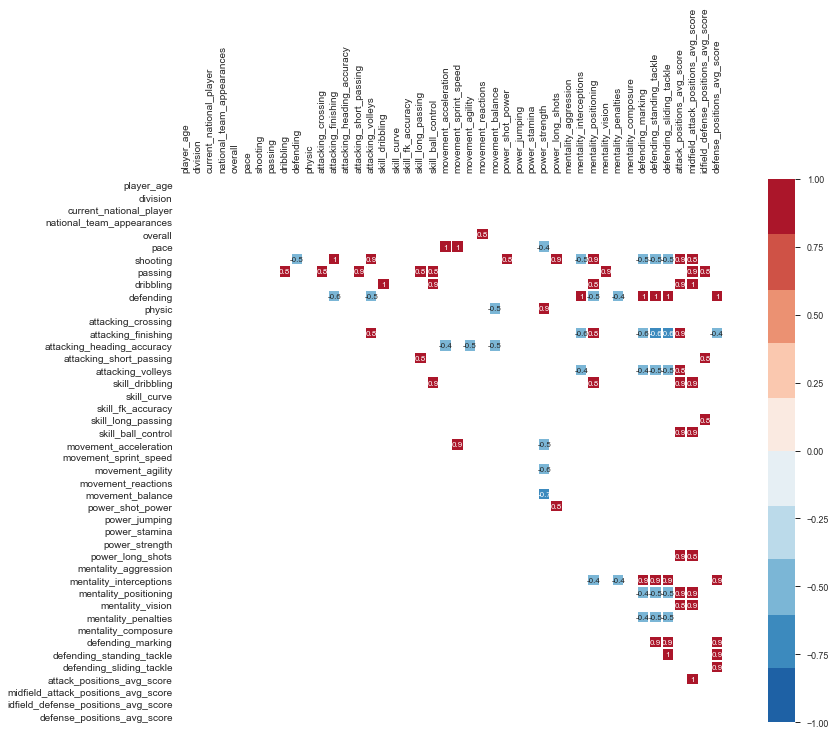

In [45]:
plot_heatmap(train_set_fp.drop(["market_value_in_euro_log"],axis=1))

In [46]:
correlated_features_fp = set()
correlation_matrix_fp = train_set_fp.corr()

for i in range(len(correlation_matrix_fp.columns)):
    for j in range(i):
        if abs(correlation_matrix_fp.iloc[i, j]) > 0.8:
            colname = correlation_matrix_fp.columns[i]
            correlated_features_fp.add(colname)

print(len(correlated_features_fp))            
print(sorted(correlated_features_fp, reverse=False))

24
['attack_positions_avg_score', 'attacking_crossing', 'attacking_finishing', 'attacking_short_passing', 'attacking_volleys', 'defending_marking', 'defending_sliding_tackle', 'defending_standing_tackle', 'defense_positions_avg_score', 'dribbling', 'idfield_defense_positions_avg_score', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'midfield_attack_positions_avg_score', 'movement_acceleration', 'movement_reactions', 'movement_sprint_speed', 'power_long_shots', 'power_shot_power', 'power_strength', 'skill_ball_control', 'skill_dribbling', 'skill_long_passing']


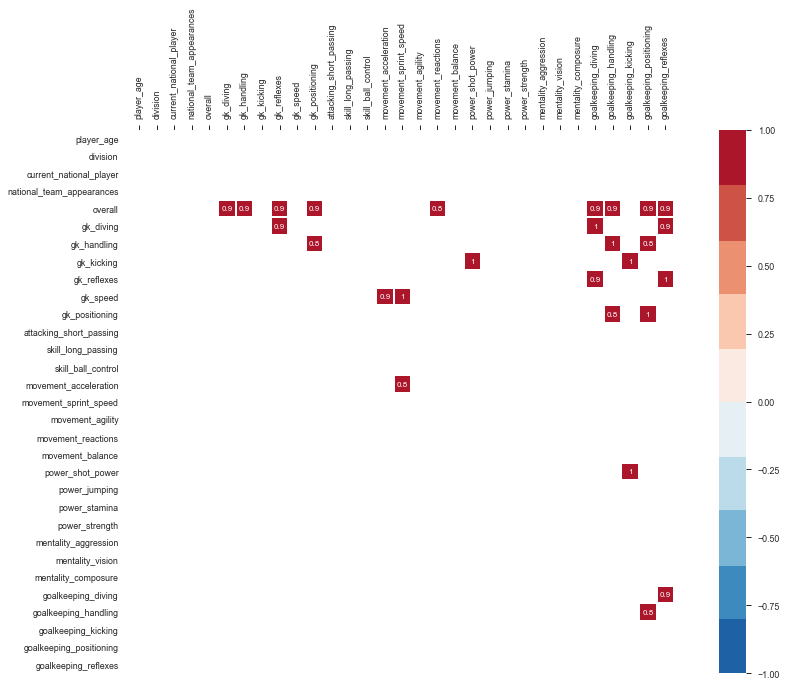

In [47]:
plot_heatmap(train_set_gk.drop(["market_value_in_euro_log"],axis=1))

In [48]:
correlated_features_gk = set()
correlation_matrix_gk = train_set_gk.corr()

for i in range(len(correlation_matrix_gk.columns)):
    for j in range(i):
        if abs(correlation_matrix_gk.iloc[i, j]) > 0.8:
            colname = correlation_matrix_gk.columns[i]
            correlated_features_gk.add(colname)

print(len(correlated_features_gk))            
print(sorted(correlated_features_gk, reverse=False))

13
['gk_diving', 'gk_handling', 'gk_positioning', 'gk_reflexes', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'movement_acceleration', 'movement_reactions', 'movement_sprint_speed', 'power_shot_power']


In [49]:
df_fp = df_fp.drop(df_fp.loc[:,'attacking_crossing':'defense_positions_avg_score'].columns, axis = 1)
df_gk = df_gk.drop(df_gk.loc[:,'gk_diving':'goalkeeping_reflexes'].columns, axis = 1)

# fieldplayers
train_set_fp = df_fp.sample(frac=0.80, random_state=rseed)
final_test_set_fp = df_fp.drop(train_set_fp.index)

# goal keepers
train_set_gk = df_gk.sample(frac=0.80, random_state=rseed)
final_test_set_gk = df_gk.drop(train_set_gk.index)

print("Fieldplayers: ")
print(train_set_fp.shape)
print(final_test_set_fp.shape)
print("-----------------------")
print("Goalkeepers: ")
print(train_set_gk.shape)
print(final_test_set_gk.shape)

Fieldplayers: 
(6426, 21)
(1606, 21)
-----------------------
Goalkeepers: 
(554, 11)
(139, 11)


# Define Pipelines

## Preprocessing Pipeline

In [50]:
def preprocessing_pipeline (train_set, scaler, encoder):

    ######################################################################
    # I. train-test-split
    ######################################################################

    from sklearn.model_selection import train_test_split

    X = train_set.drop(["market_value_in_euro_log"],axis=1)

    y = train_set["market_value_in_euro_log"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rseed)

    ###################################
    # II. Build preprocessing pipeline with
    # - a scaler for numerical columns
    # - an encoder for categorical columns
    # --> scaler and encoder need to be imported before function is called
    ###################################

    from sklearn.pipeline import Pipeline  

    numeric_transformer = Pipeline(steps=[
        ('scaler', scaler)])

    categorical_transformer = Pipeline(steps=[
        ('encoder', encoder)])

    ######################################################################
    # III. Apply column transformer
    ######################################################################

    from sklearn.compose import ColumnTransformer

    numerical_features = train_set.select_dtypes(include=['int64', 'float64']).drop(["market_value_in_euro_log"],axis=1).columns
    categorical_features = train_set.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features)])
    
    X_train_pre = preprocessor.fit_transform(X_train)
    X_test_pre = preprocessor.fit_transform(X_test)
    
    ######################################################################
    # IV. Extract column names for feature importances later on
    ######################################################################
    
    
    numerical_features_names = list(numerical_features)
    encoded_categorical_features = preprocessor.named_transformers_["cat"]["encoder"]
    encoded_categorical_features_names = list(encoded_categorical_features.get_feature_names(categorical_features))
    column_names = numerical_features_names + encoded_categorical_features_names

    return X, y, X_train, X_train_pre, X_test, X_test_pre, y_train, y_test, column_names, preprocessor  

## Model Selection Pipeline

Regressors to be tested:
1. Linear Regression
6. Stochastic Gradient Descent
7. Decision Trees
8. Random Forest
9. AdaBoost
10. Gradient Tree Boosting
11. XGBoost


In [51]:
def model_selection_pipeline (preprocessor_pipeline, scoring="r2"):
    
    # get processed data from preprocessing pipeline
    X, y, X_train, X_train_pre, X_test, X_test_pre, y_train, y_test, column_names, preprocessor = preprocessor_pipeline

    ######################################################################
    # I. Define and import relevant algorithms
    ######################################################################

    from sklearn import linear_model
    from sklearn import svm
    from sklearn import tree
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import AdaBoostRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    import xgboost as xgb
    

    models = []
    models.append(("Linear Regression",linear_model.LinearRegression()))
    models.append(("SGD",linear_model.SGDRegressor(random_state=rseed)))
    models.append(("Decision Tree",tree.DecisionTreeRegressor(random_state=rseed)))
    models.append(("Random Forest",RandomForestRegressor(random_state=rseed,n_jobs=-1)))
    models.append(("AdaBoost",AdaBoostRegressor(random_state=rseed)))
    models.append(("GradientBoosting",GradientBoostingRegressor(random_state=rseed)))
    models.append(("XGBoost",xgb.XGBRegressor(objective="reg:squarederror" ,random_state=rseed)))
    

    results = []
    names = []
    scoring = scoring
    
    ######################################################################
    # II. Fit models and calculate metric for each model
    ######################################################################
    
    from sklearn.pipeline import Pipeline
    
    from sklearn import model_selection
    from sklearn.model_selection import cross_val_score
    import math
    
    for name,regressor in models:
        
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', regressor)])
        
        pipe.fit(X_train, y_train)
        
        kfold = model_selection.KFold(n_splits=5, random_state=rseed, shuffle=True)
        cv_results = abs(model_selection.cross_val_score(pipe, X, y, cv=kfold, scoring=scoring))
        cv_mean = math.ceil(cv_results.mean())
        cv_std = math.ceil(cv_results.std())
        results.append(cv_results)
        names.append(name)
        
        from yellowbrick.regressor import residuals_plot
        from yellowbrick.datasets import load_concrete
        
        print(f"Residual plot for {name}")
        viz = residuals_plot(pipe, X_train, y_train, X_test, y_test, hist=False)

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

Residual plot for Linear Regression


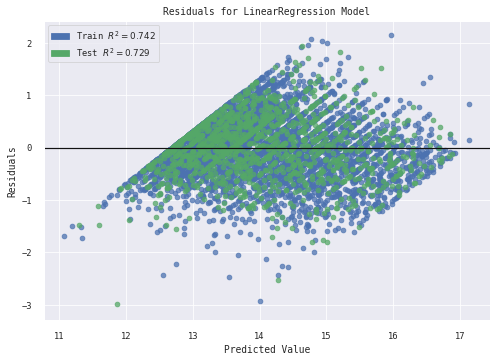

Residual plot for SGD


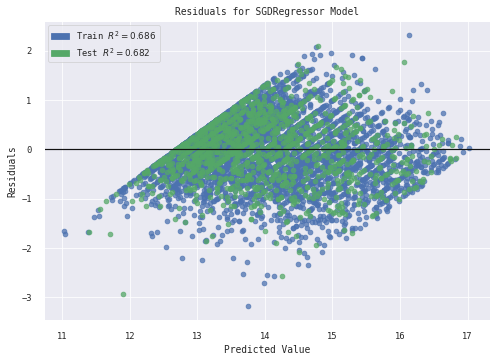

Residual plot for Decision Tree


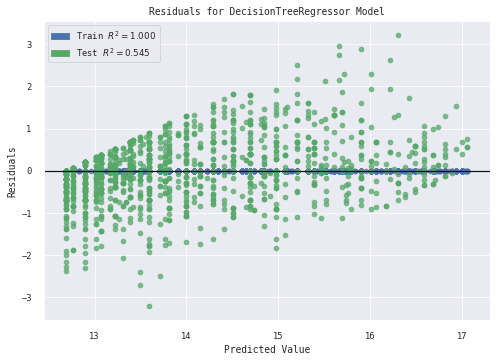

Residual plot for Random Forest


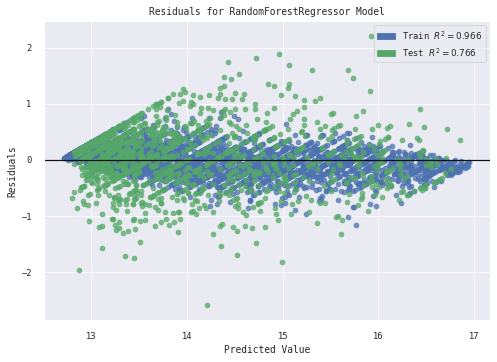

Residual plot for AdaBoost


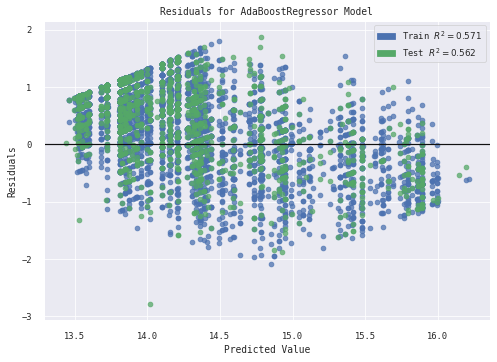

Residual plot for GradientBoosting


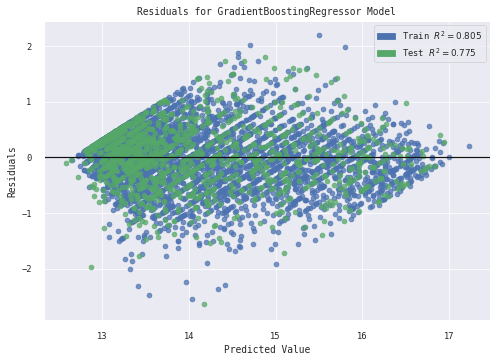

Residual plot for XGBoost


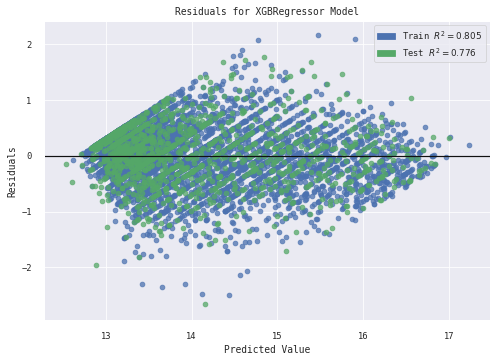

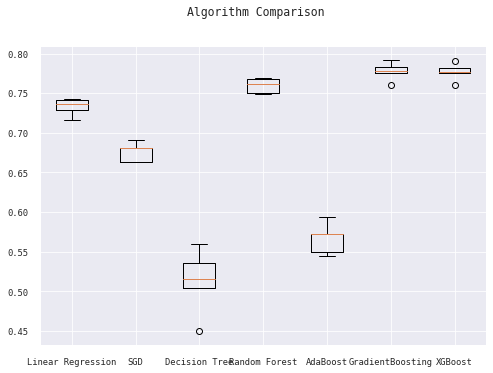

In [52]:
model_selection_pipeline (preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()))

##### --> Best 3 performing algorithms (in terms of R-squared) are Random Forest, GradientBoost and XGBoost!

##### --> these are also our baseline models!

## RandomSearchCV Pipeline

narrow down, where to look for with gridsearch afterward (not applicable for linear Regression)

In [53]:
def randomsearch_pipeline(preprocessor_pipeline, model_name, model, param_distributions, scoring="r2"):
    
    # model needs to be a tuple of "(name, regressor)"
    
    # get processed data from preprocessing pipeline
    X, y, X_train, X_train_pre, X_test, X_test_pre, y_train, y_test, column_names, preprocessor  = preprocessor_pipeline

    ###################################
    # I. 
    ###################################
    
    from sklearn.model_selection import RandomizedSearchCV
    
    param_distributions = param_distributions
    

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])


    grid = RandomizedSearchCV(pipe, param_distributions = param_distributions, n_iter = 100, cv=3, scoring=scoring, random_state=rseed, n_jobs=-1)

    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)

    print("----------------------------------------------------------------------------------------------------------")
    print("\033[1m",model_name,"\033[0m")
    print("----------------------------------------------------------------------------------------------------------")
    print("Best hyperparameters:")
    print(grid.best_params_)
    print("-----------------------")
    print("Best score:")
    print(grid.best_score_)
    print("-----------------------")

In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_distributions ={
'model__bootstrap': [True, False],
'model__max_depth': [1,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
'model__max_features': ['auto', 'sqrt'],
'model__min_samples_leaf': [1, 2, 4, 6],
'model__min_samples_split': [1, 2, 5, 10],
'model__n_estimators': [1, 20, 50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

randomsearch_pipeline (preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()),
                       "Random Forest",RandomForestRegressor(random_state=rseed,n_jobs=-1),param_distributions)

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

param_distributions ={
    'model__learning_rate': [0.15,0.1,0.03, 0.05,0.07, 0.01,0.005,0.001],
    'model__n_estimators':[100,250,500,750,1000,1250,1500,1750],
    'model__max_depth':[1,2,3,4,5,6,7],
    'model__min_samples_split':[1,2,4,6,8,10,20,40,60,80, 100],
    'model__min_samples_leaf':[1,3,5,7,9,11,13,15],
    'model__max_features':[1,2,3,4,5,6,7],
    'model__subsample':[0.5, 0.55, 0.6, 0.65, 0.7,0.75,0.8,0.85,0.9,0.95,1]
}

randomsearch_pipeline (preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()),
                       "GradientBoosting",GradientBoostingRegressor(random_state=rseed),param_distributions)

----------------------------------------------------------------------------------------------------------
 GradientBoosting 
----------------------------------------------------------------------------------------------------------
Best hyperparameters:
{'model__subsample': 0.75, 'model__n_estimators': 1750, 'model__min_samples_split': 20, 'model__min_samples_leaf': 11, 'model__max_features': 7, 'model__max_depth': 7, 'model__learning_rate': 0.03}
-----------------------
Best score:
0.7106342314157014
-----------------------


In [14]:
import xgboost as xgb

param_distributions ={
    "model__learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.10, 0.15, 0.20, 0.25, 0.30] ,
    "model__max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "model__min_child_weight": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    "model__gamma": [0.0, 0.1, 0.2 , 0.3, 0.4],
    "model__colsample_bytree":[ 0.3, 0.4, 0.5 , 0.7, 0.8, 0.9],
    "model__subsample":[0.5, 0.55, 0.6, 0.65, 0.7,0.75,0.8,0.85,0.9,0.95,1],
    "model__reg_alpha":[1e-5, 1e-2, 0.1, 0.5, 1, 10, 50, 100]
}

randomsearch_pipeline (preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()),
                       "XGBoost",xgb.XGBRegressor(objective= "reg:squarederror", random_state=rseed),param_distributions)

[13:10:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------------------------------------------------------------------------------------------------------
 XGBoost 
----------------------------------------------------------------------------------------------------------
Best hyperparameters:
{'model__subsample': 0.9, 'model__reg_alpha': 10, 'model__min_child_weight': 11, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__gamma': 0.0, 'model__colsample_bytree': 0.8}
-----------------------
Best score:
0.7423875772159785
-----------------------


## GridSearchCV Pipeline

In [32]:
def gridsearch_pipeline(preprocessor_pipeline, model_name, model, param_grid, scoring="r2"):
    
    # model needs to be a tuple of "(name, regressor)"
    
    # get processed data from preprocessing pipeline
    X, y, X_train, X_train_pre, X_test, X_test_pre, y_train, y_test, column_names, preprocessor = preprocessor_pipeline

    ###################################
    # I. 
    ###################################
    
    from sklearn.model_selection import GridSearchCV
    
    param_grid = param_grid
    

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])


    grid = RandomizedSearchCV(pipe, param_grid = param_grid, cv=5, scoring=scoring, random_state=rseed, n_jobs=-1)

    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)

    print("----------------------------------------------------------------------------------------------------------")
    print("\033[1m",model_name,"\033[0m")
    print("----------------------------------------------------------------------------------------------------------")
    print("Best hyperparameters:")
    print(grid.best_params_)
    print("-----------------------")

    # features importances

    feature_importances = grid.best_estimator_.named_steps["regressor"].feature_importances_
    feat_imp_df = pd.DataFrame({'feature':column_names,'importance':feature_importances})
    feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
    print("Feature importances:")
    print("------------------------------------------------------------")
    print(feat_imp_df.head(20))
    print("------------------------------------------------------------")
    print("------------------------------------------------------------")
    # Visualization of residuals

    from yellowbrick.regressor import residuals_plot
    from yellowbrick.datasets import load_concrete

    print(f"Residual plot for {model_name}")
    viz = residuals_plot(grid, X_train, y_train, X_test, y_test, hist=False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_grid ={
'model__bootstrap': [XXX],
'model__max_depth': [XXX, XXX, XXX],
'model__max_features': [XXX],
'model__min_samples_leaf': [XXX, XXX, XXX],
'model__min_samples_split': [XXX, XXX, XXX],
'model__n_estimators': [XXX, XXX, XXX]
}

gridsearch_pipeline (preprocessing_pipeline(train_set_fp, MinMaxScaler(), OneHotEncoder()),
                       "Random Forest",RandomForestRegressor(random_state=rseed,n_jobs=-1),param_grid)

## Stacking Pipeline (with optimal hyperparameters from GridSearch)

##### stacking model function will be defined here for later

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html

In [ ]:
# stacking model for later

### need to give in list with tuples of (name, regressor)
### can be given from algo function above

    from sklearn.ensemble import StackingRegressor
    
    stacked_model = StackingRegressor(
        estimators = fitted_models,
        final_estimator=RandomForestRegressor(n_estimators=10,random_state=rseed)
    )
    
    stacked_model.fit(X_train, y_train).score(X_test, y_test)

In [ ]:
######metric calculation

# put together datasets again
df_fp_train = X_train.copy()
df_fp_train["y_actual"] = y_train
df_fp_train["y_predicted"] = y_pred_train

df_fp_test = X_test.copy()
df_fp_test["y_actual"] = y_test
df_fp_test["y_predicted"] = y_pred_test

# calculate residuals
df_fp_train["residuals"] = df_fp_train["y_actual"] - df_fp_train["y_predicted"]
df_fp_test["residuals"] = df_fp_test["y_actual"] - df_fp_test["y_predicted"]


# calculate R2 score
ssr_train = np.sum((df_fp_train["y_predicted"] - df_fp_train["y_actual"])**2)
ssr_test = np.sum((df_fp_test["y_predicted"] - df_fp_test["y_actual"])**2)

sst_train = np.sum((df_fp_train["y_actual"] - np.mean(df_fp_train["y_actual"]))**2)
sst_test = np.sum((df_fp_test["y_actual"] - np.mean(df_fp_test["y_actual"]))**2)

r2_score_train = 1 - (ssr_train/sst_train)
r2_score_test = 1 - (ssr_test/sst_test)

print(round(r2_score_train,3))
print(round(r2_score_test,3))

# todos

- richtige GridSearch vor der Pipeline
- Stacking Pipeline mit den Gridparametern
- Dashboard